# Análise Exploratória dos Dados (EDA)

### 1. Introdução ao RAVDESS Dataframe

#### Aqui está um exemplo de um nome de arquivo de áudio conforme descrito no site oficial do RAVDESS:
    - Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
    - Vocal channel (01 = speech, 02 = song).
    - Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
    - Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
    - Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
    - Repetition (01 = 1st repetition, 02 = 2nd repetition).
    - Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

#### Aqui está um exemplo do aúdio 02-01-06-01-02-01-12.mp4. Isso significa que os metadados para esse arquivo de áudio são:
    - Video-only (02)
    - Speech (01)
    - Fearful (06)
    - Normal intensity (01)
    - Statement "dogs" (02)
    - 1st Repetition (01)
    - 12th Actor (12) - Female (as the actor ID number is even)

### 2. Criando um DataFrame sobre os arquivos de áudio do dataset RAVDESS

#### 2.1. Importando as bibliotecas

In [1]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#### 2.2. Criando o dataframe

In [7]:
Ravdess = "C:/Users/kawan/Downloads/1188976/Audio_Speech_Actors_01-24/" # Mude para o seu path

In [8]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # As their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # Third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# Changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,neutral,C:/Users/kawan/Downloads/1188976/Audio_Speech_...
1,neutral,C:/Users/kawan/Downloads/1188976/Audio_Speech_...
2,neutral,C:/Users/kawan/Downloads/1188976/Audio_Speech_...
3,neutral,C:/Users/kawan/Downloads/1188976/Audio_Speech_...
4,calm,C:/Users/kawan/Downloads/1188976/Audio_Speech_...


### 3. Limpeza dos Dados
- Agora que criamos o nosso Dataframe, precisamos nos certificar que ele está limpo de erros e pronto para os próximos passos.

#### 3.1. Verificando se há arquivos corrompidos, muito curtos ou com problemas de leitura

In [9]:
def check_audio_files(df, sample_rate=22050):
    # Verifique se há arquivos muito curtos (menos de 1 segundo) ou corrompidos, caso não, tudo bem :)
    # Code here

    valid_files = []
    invalid_files = []
    
    for index, row in df.iterrows():
        file_path = row['Path']  # Assumindo que o DataFrame tem uma coluna 'Path'
        
        try:
            # Carrega o arquivo de áudio
            audio, sr = librosa.load(file_path, sr=sample_rate)
            
            # Calcula a duração em segundos
            duration = librosa.get_duration(y=audio, sr=sr)
            
            # Verifica se o áudio é muito curto (< 1 segundo)
            if duration < 1.0:
                invalid_files.append((file_path, "Áudio muito curto (< 1s)"))
            else:
                valid_files.append(file_path)
        
        except Exception as e:
            # Se houver erro ao carregar, o arquivo está corrompido
            invalid_files.append((file_path, f"Erro ao carregar: {str(e)}"))

        
    return valid_files, invalid_files

# Verificar os arquivos do dataset
valid_files, invalid_files = check_audio_files(Ravdess_df)

# Filtrar o DataFrame para manter apenas os arquivos válidos
Ravdess_df = Ravdess_df[Ravdess_df["Path"].isin(valid_files)]

print(f"Arquivos válidos: {len(valid_files)}")
print(f"Arquivos inválidos/removidos: {len(invalid_files)}")

Arquivos válidos: 1440
Arquivos inválidos/removidos: 0


### 4. Exploração e Visualização dos Dados

#### 4.1. Visualizando quais são as principais emoções presentes em nosso dataframe

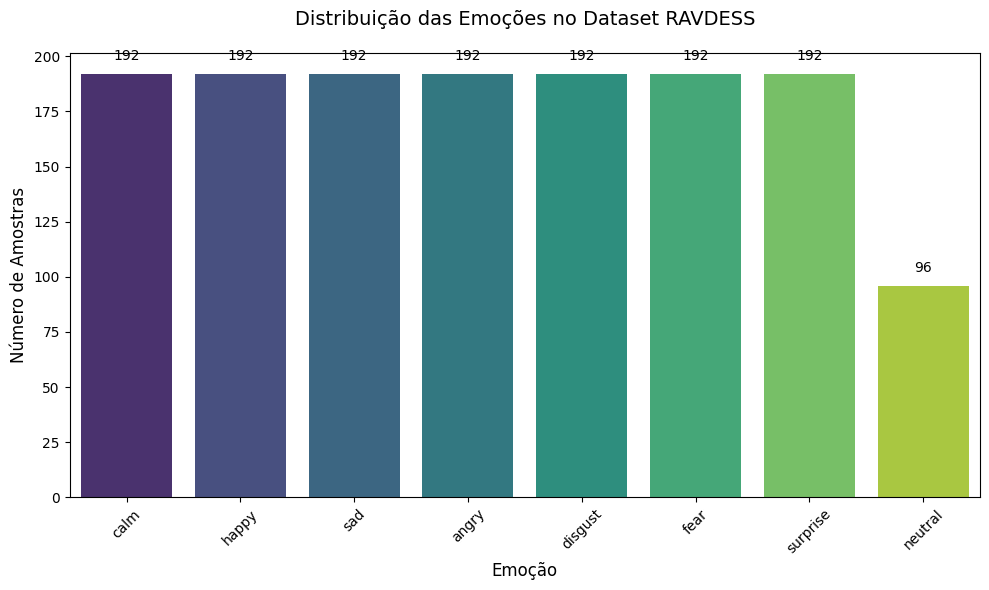

In [ ]:
# Plote um gráfico mostrando as principais emoções do dataframe
# Code here
def plot_emotion_distribution(df, emotion_column='Emotions'):
    plt.figure(figsize=(10, 6))
    
    # Conta a frequência de cada emoção
    emotion_counts = df[emotion_column].value_counts()
    
    # Cria um gráfico de barras
    sns.barplot(
        x=emotion_counts.index,
        y=emotion_counts.values,
        palette="viridis"  # Pode alterar para "coolwarm", "magma", etc.
    )
    
    # Adiciona rótulos e título
    plt.title("Distribuição das Emoções no Dataset RAVDESS", fontsize=14, pad=20)
    plt.xlabel("Emoção", fontsize=12)
    plt.ylabel("Número de Amostras", fontsize=12)
    plt.xticks(rotation=45)  # Rotaciona os rótulos para melhor legibilidade
    
    # Adiciona os valores em cima de cada barra
    for i, count in enumerate(emotion_counts.values):
        plt.text(i, count + 5, str(count), ha='center', va='bottom')
    
    plt.tight_layout()  # Ajusta o layout para evitar cortes
    plt.show()

# Uso:
plot_emotion_distribution(Ravdess_df)

#### 4.2. Plotando o sinal de aúdio em forma de onda e em espectograma
- Forma de Onda - Os Waveplots nos permitem visualizar a intensidade (volume) do áudio em um determinado momento.
- Espectrogramas - Um espectrograma é uma representação visual do espectro de frequências de um som ou de outros sinais à medida que variam ao longo do tempo. Ele mostra como as frequências mudam em relação ao tempo para um determinado sinal de áudio.

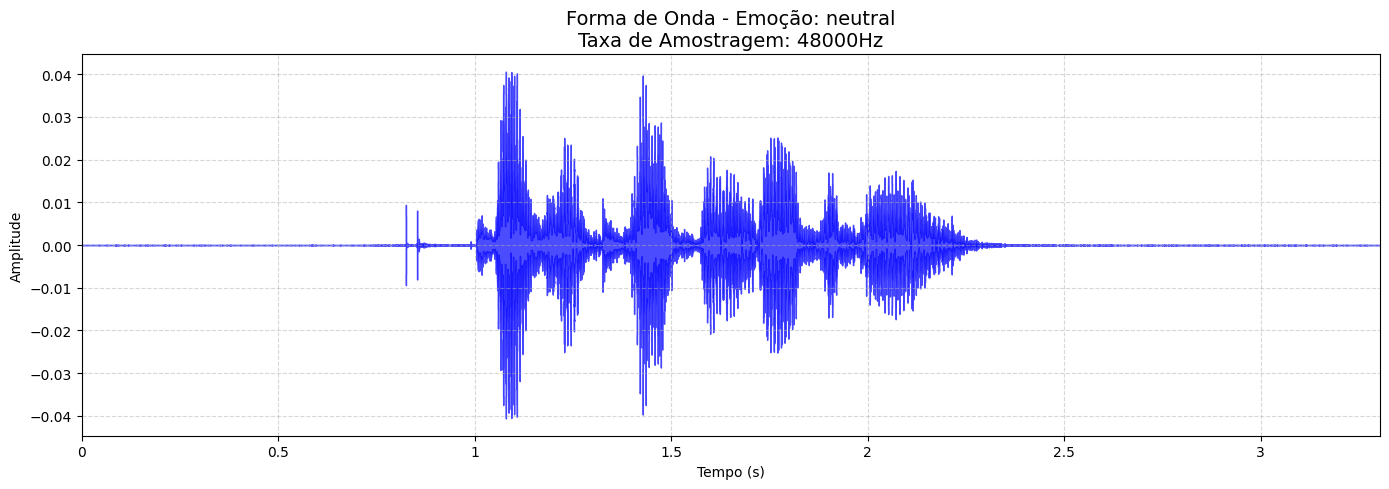

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(14, 5))
    
    try:
        # Versão moderna do librosa (>= 0.8.0)
        librosa.display.waveshow(data, sr=sr, alpha=0.7, color='blue')
    except AttributeError:
        # Fallback para versões mais antigas
        librosa.display.waveplot(data, sr=sr, alpha=0.7, color='blue')
    
    plt.title(f'Forma de Onda - Emoção: {e}\nTaxa de Amostragem: {sr}Hz', fontsize=14)
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude')
    
    # Adiciona grid para melhor leitura
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Ajusta os limites do eixo x para evitar espaços vazios
    plt.xlim([0, len(data)/sr])
    
    plt.tight_layout()
    plt.show()


primeiro_arquivo = Ravdess_df['Path'].iloc[0]  # Pega o primeiro arquivo

dados_audio, sr = librosa.load(primeiro_arquivo, sr=None)
emocao = Ravdess_df['Emotions'].iloc[0]  # Pega a emoção correspondente

# Chame sua função
create_waveplot(dados_audio, sr, emocao)

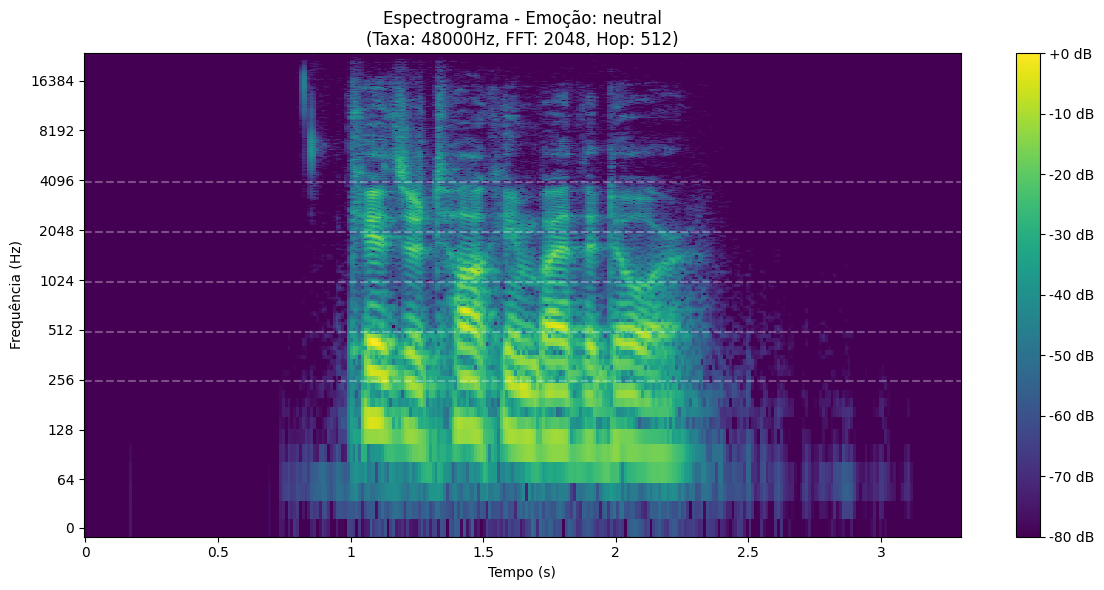

In [17]:
def create_spectrogram(data, sr, e, n_fft=2048, hop_length=512, cmap='viridis'):
    
    plt.figure(figsize=(12, 6))
    
    # Calcula o STFT (Short-Time Fourier Transform)
    stft = librosa.stft(data, n_fft=n_fft, hop_length=hop_length)
    
    # Converte amplitude para dB (escala logarítmica)
    spectrogram = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
    
    # Plota o espectrograma
    librosa.display.specshow(spectrogram, sr=sr, 
                            hop_length=hop_length, 
                            x_axis='time', 
                            y_axis='log',
                            cmap=cmap)
    
    # Configurações do gráfico
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Espectrograma - Emoção: {e}\n(Taxa: {sr}Hz, FFT: {n_fft}, Hop: {hop_length})', fontsize=12)
    plt.xlabel('Tempo (s)')
    plt.ylabel('Frequência (Hz)')
    plt.tight_layout()
    
    # Adiciona linha das frequências importantes para análise de voz
    for freq in [250, 500, 1000, 2000, 4000]:  # Frequências típicas de formantes vocais
        plt.axhline(y=freq, color='w', linestyle='--', alpha=0.3)
    
    plt.show()

primeiro_arquivo = Ravdess_df['Path'].iloc[0]  # Pega o primeiro arquivo

dados_audio, sr = librosa.load(primeiro_arquivo, sr=None)
emocao = Ravdess_df['Emotions'].iloc[0]  # Pega a emoção correspondente
create_spectrogram(dados_audio, sr, emocao)  # Substitua "feliz" pela emoção real

#### Agora rode as células abaixo para ver os resultados do que você fez :)

#### Emoção de Medo

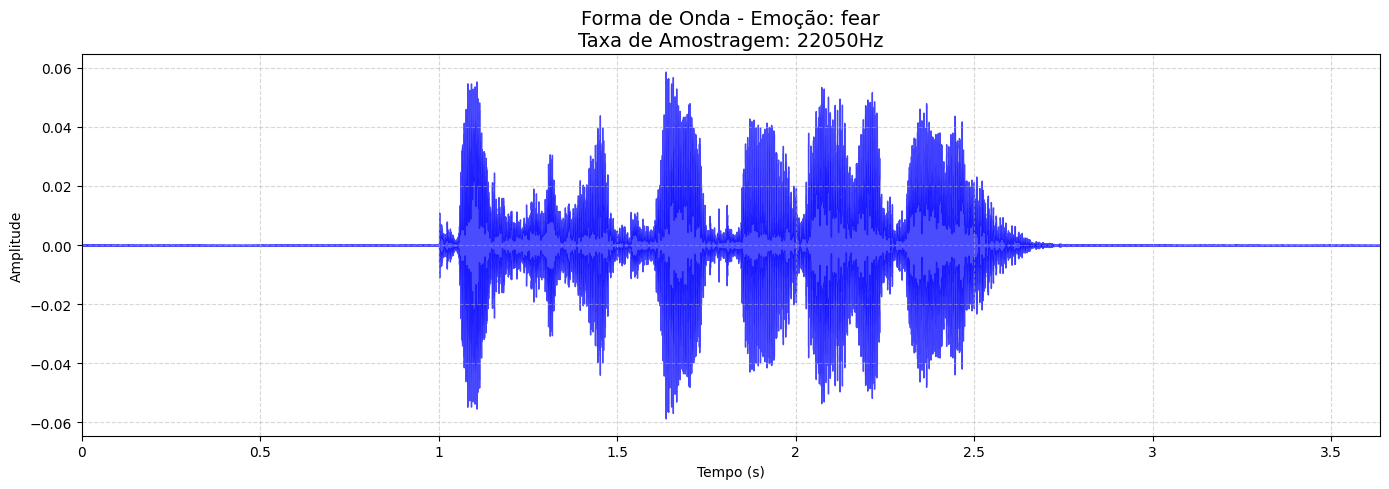

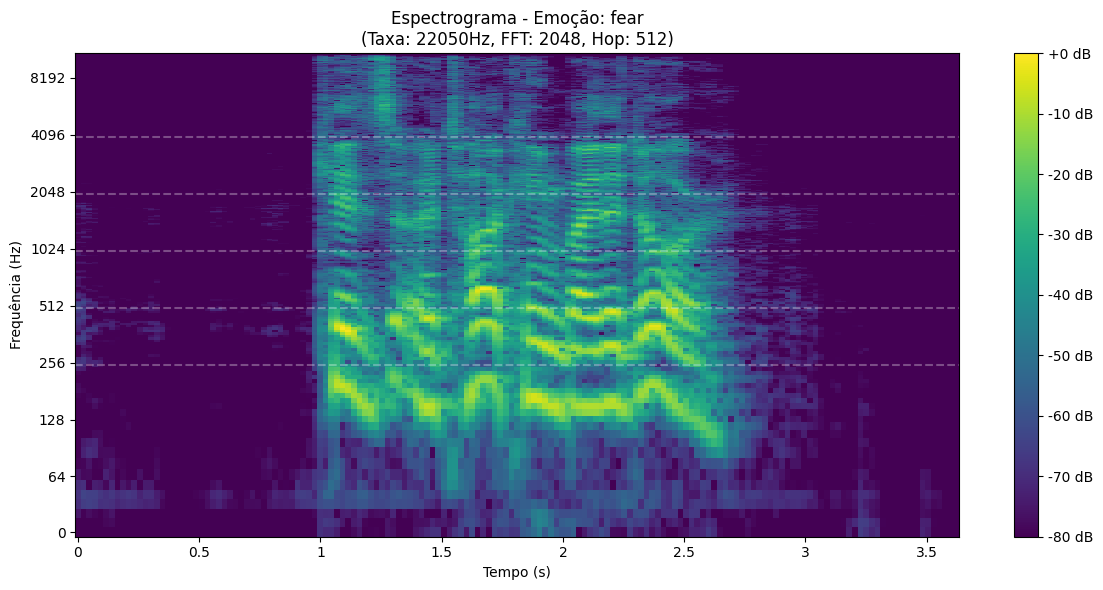

In [18]:
emotion='fear'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

#### Emoção de felicidade

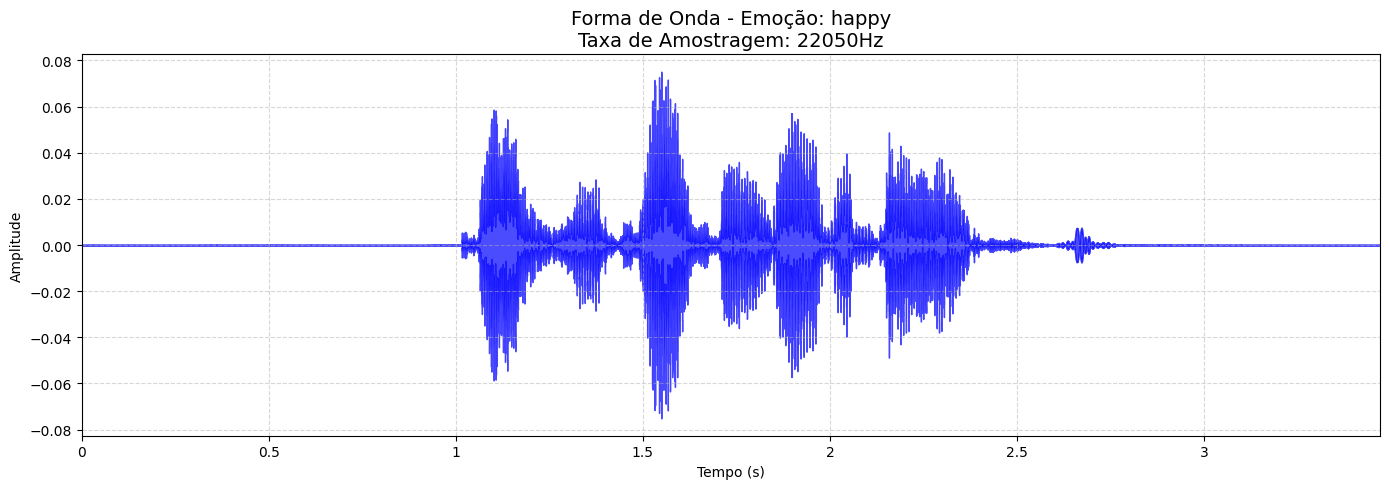

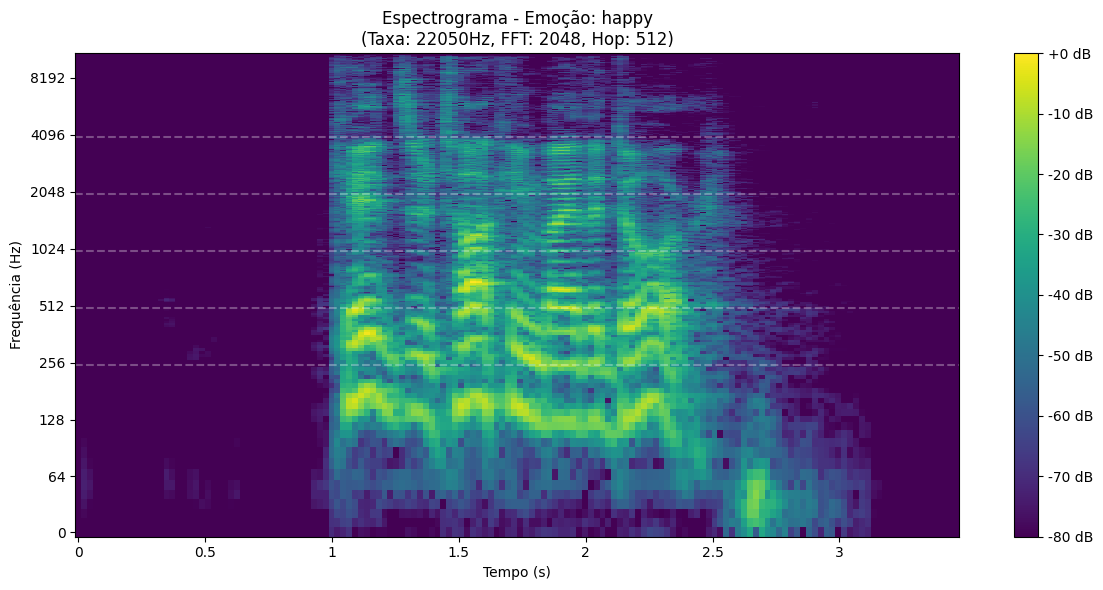

In [19]:
emotion='happy'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

#### 4.3. Analisar a duração dos áudios

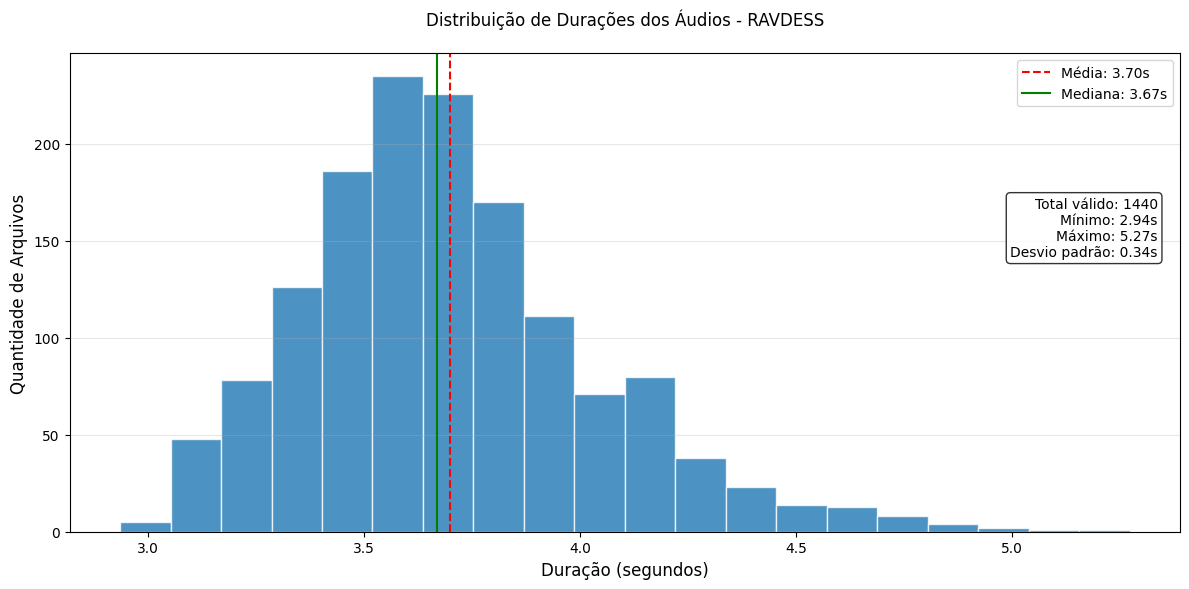

In [21]:
# Plote um histograma para ver como está a distribuição da duração dos aúdios no dataset
# Code here

def plot_duration_histogram(df, path_column='Path', bins=20, sr=None):
   
    durations = []
    problematic_files = []
    
    # Calcula as durações
    for path in df[path_column]:
        try:
            y, sr_loaded = librosa.load(path, sr=sr, mono=True)
            duration = librosa.get_duration(y=y, sr=sr_loaded)
            durations.append(duration)
        except Exception as e:
            problematic_files.append(path)
    
    # Mostra arquivos problemáticos
    if problematic_files:
        print(f"Arquivos com problemas ({len(problematic_files)}):")
        for path in problematic_files[:3]:  # Mostra no máximo 3
            print(f"- {path}")
    
    # Criação do gráfico
    plt.figure(figsize=(12, 6))
    
    # Histograma principal
    n, bins, patches = plt.hist(durations, bins=bins, 
                               color='#1f77b4', 
                               edgecolor='white',
                               alpha=0.8)
    
    # Linhas de referência
    mean_val = np.mean(durations)
    median_val = np.median(durations)
    plt.axvline(mean_val, color='red', linestyle='--', linewidth=1.5, label=f'Média: {mean_val:.2f}s')
    plt.axvline(median_val, color='green', linestyle='-', linewidth=1.5, label=f'Mediana: {median_val:.2f}s')
    
    # Estatísticas
    stats_text = (f"Total válido: {len(durations)}\n"
                 f"Mínimo: {min(durations):.2f}s\n"
                 f"Máximo: {max(durations):.2f}s\n"
                 f"Desvio padrão: {np.std(durations):.2f}s")
    
    plt.gca().annotate(stats_text, xy=(0.98, 0.7), xycoords='axes fraction',
                      ha='right', va='top', 
                      bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Formatação
    plt.title('Distribuição de Durações dos Áudios - RAVDESS', pad=20)
    plt.xlabel('Duração (segundos)', fontsize=12)
    plt.ylabel('Quantidade de Arquivos', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Uso com o DataFrame
plot_duration_histogram(Ravdess_df)

### 5. Aumento de Dados (Data Augmentation)
- O aumento de dados é o processo pelo qual criamos novas amostras sintéticas de dados adicionando pequenas perturbações ao nosso conjunto de treinamento original.
- Para gerar dados sintéticos para áudio, podemos aplicar injeção de ruído, deslocamento no tempo, alteração de tom (pitch) e velocidade.
- O objetivo é tornar nosso modelo invariante a essas perturbações e melhorar sua capacidade de generalização.
- Para que isso funcione, as perturbações adicionadas devem manter o mesmo rótulo da amostra de treinamento original.
- No caso de imagens, o aumento de dados pode ser realizado por meio de deslocamento, zoom, rotação, entre outras técnicas.

Agora, vamos verificar quais técnicas de aumento de dados funcionam melhor para o nosso conjunto de dados :)

In [23]:
def noise(data,noise_level=0.005, random_noise=True):
    # Gere um valor de amplitude de ruído (baseado no valor máximo no dataset) e adicione ruído normal (gaussiano) ao dataset original
    # Code here
    if not random_noise:
        np.random.seed(42)  # Semente fixa para experimentos controlados
    
    # Calcula a amplitude máxima do sinal original
    max_amplitude = np.max(np.abs(data))
    
    # Gera ruído gaussiano com mesma forma que o sinal original
    noise_amp = noise_level * max_amplitude
    gaussian_noise = np.random.normal(0, noise_amp, len(data))
    
    # Adiciona o ruído ao sinal original
    noisy_data = data + gaussian_noise
    
    # Garante que não ultrapasse os limites [-1, 1] para áudio normalizado
    return np.clip(noisy_data, -1.0, 1.0)


def stretch(data, rate=0.8):
    """Estica ou comprime o áudio no tempo sem alterar o pitch."""
    rate = np.clip(rate, 0.5, 2.0)
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    """Desloca o áudio no tempo usando numpy.random (sem módulo random)."""
    max_shift = len(data) // 2
    # Usando numpy.random em vez do módulo random
    shift_amount = np.random.randint(-max_shift, max_shift)
    return np.roll(data, shift_amount)

def pitch(data, sampling_rate, pitch_factor=0.7):
    """Altera o pitch do áudio sem mudar sua duração."""
    pitch_factor = np.clip(pitch_factor, 0.5, 2.0)
    n_steps = 12 * np.log2(pitch_factor)
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=n_steps)

# Taking any example and checking for techniques.
path = np.array(Ravdess_df.Path)[1]
data, sample_rate = librosa.load(path)

# Aplicando as transformações
stretched_audio = stretch(data, rate=0.8)  # 20% mais rápido
shifted_audio = shift(data)               # Deslocamento aleatório
pitched_audio = pitch(data, sr, 1.2)      # Pitch 20% mais agudo

# Combinação de transformações (data augmentation avançado)
augmented_audio = pitch(shift(stretch(data, 0.9)), sr, 1.1)

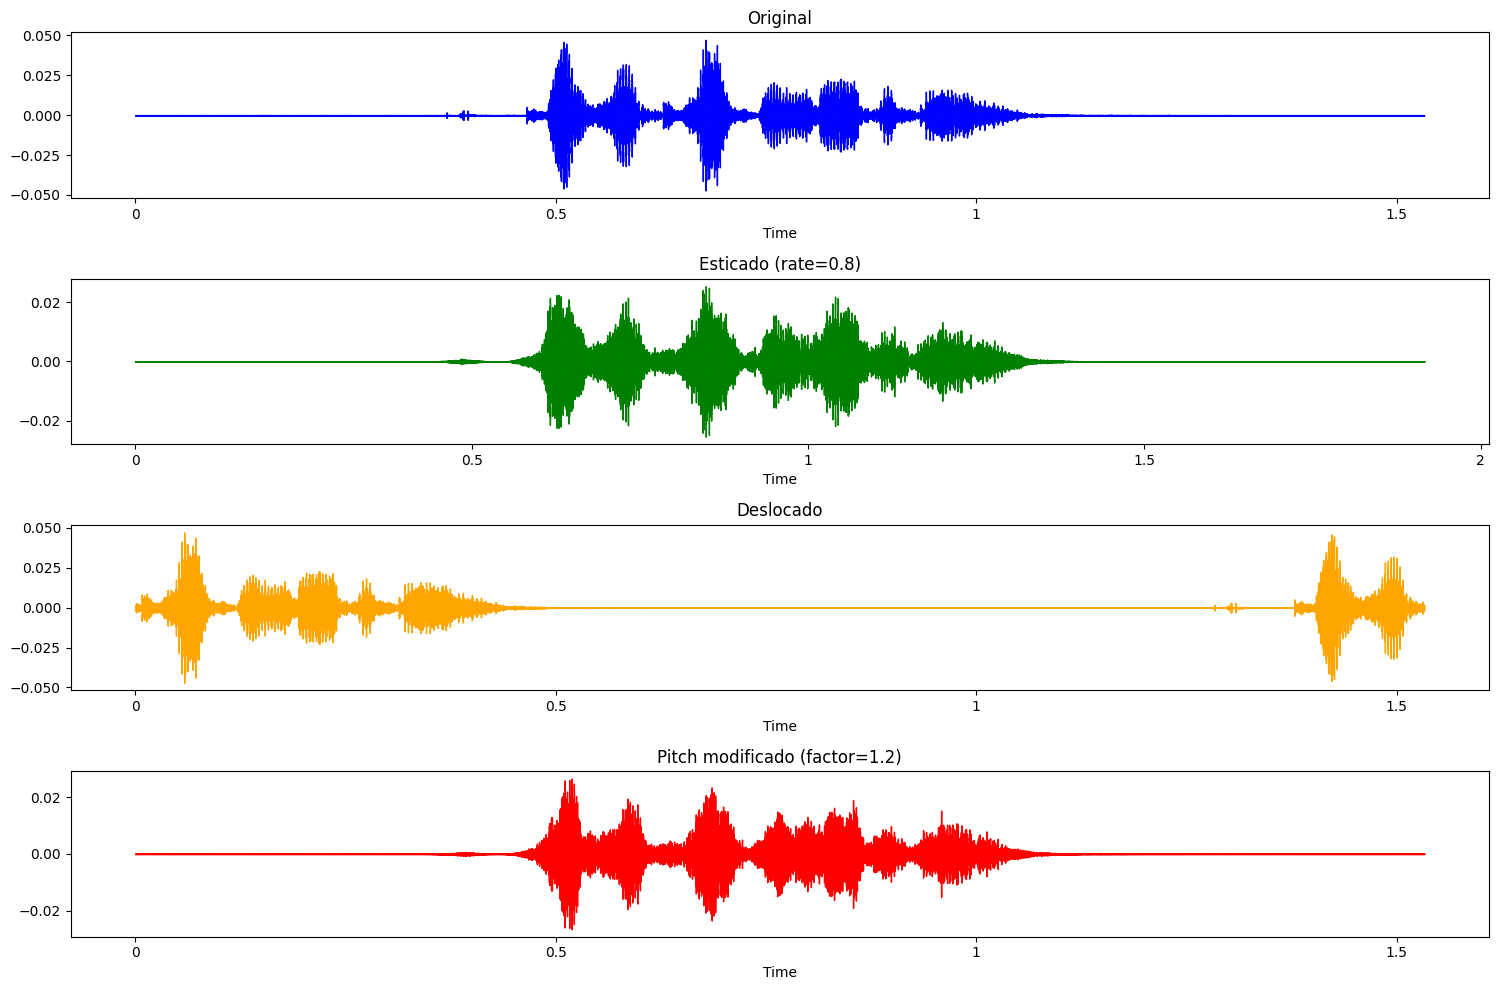

In [24]:
plt.figure(figsize=(15, 10))

plt.subplot(4, 1, 1)
librosa.display.waveshow(data, sr=sr, color='blue')
plt.title("Original")

plt.subplot(4, 1, 2)
librosa.display.waveshow(stretched_audio, sr=sr, color='green')
plt.title("Esticado (rate=0.8)")

plt.subplot(4, 1, 3)
librosa.display.waveshow(shifted_audio, sr=sr, color='orange')
plt.title("Deslocado")

plt.subplot(4, 1, 4)
librosa.display.waveshow(pitched_audio, sr=sr, color='red')
plt.title("Pitch modificado (factor=1.2)")

plt.tight_layout()
plt.show()

#### 5.1. Simple Audio

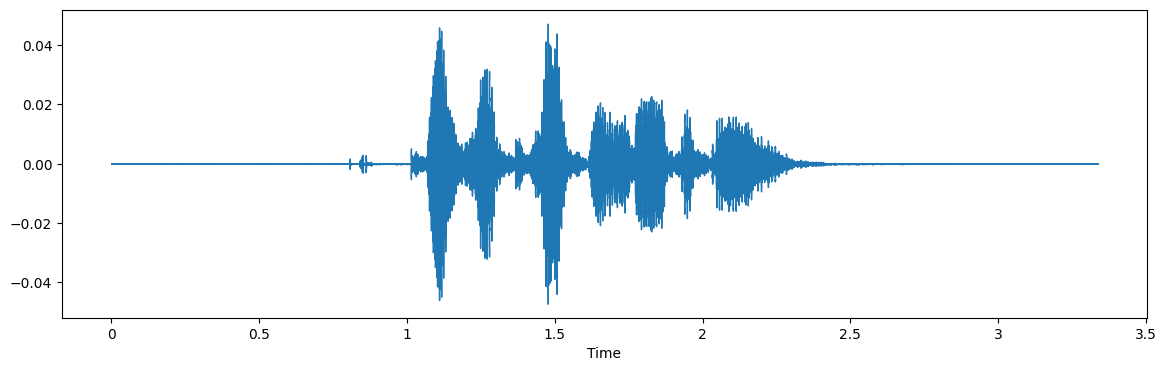

In [25]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

#### 5.2. Noise Injection (Injeção de ruído)

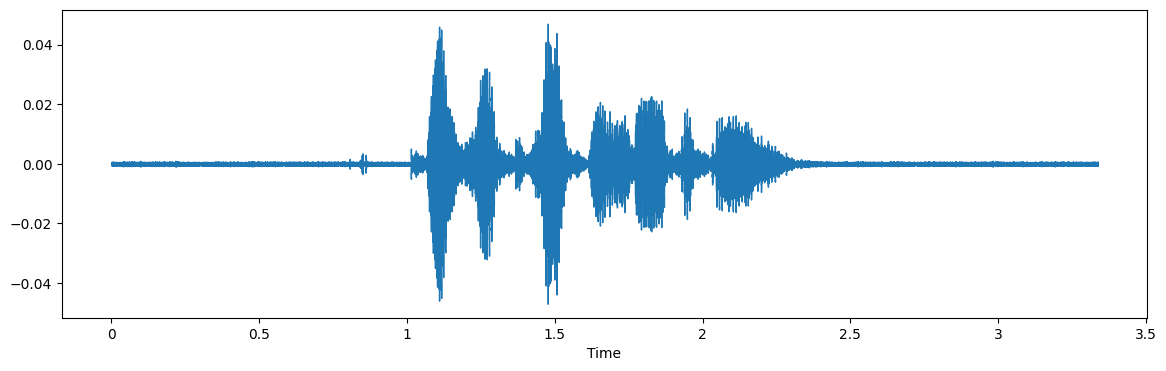

In [26]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5.3. Stretching (Alongamento)
- Mudando a velocidade do aúdio

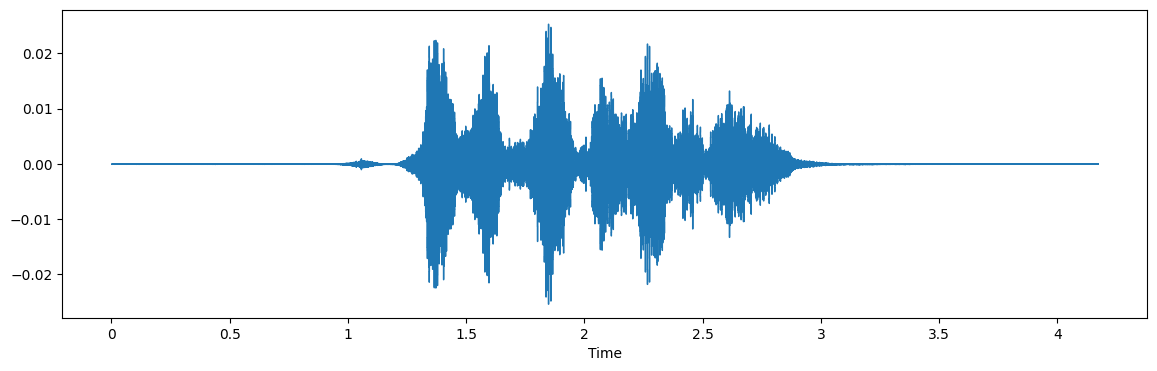

In [27]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5.4. Shifting (Deslocamento)
- Estou deslocando o sinal de áudio no tempo

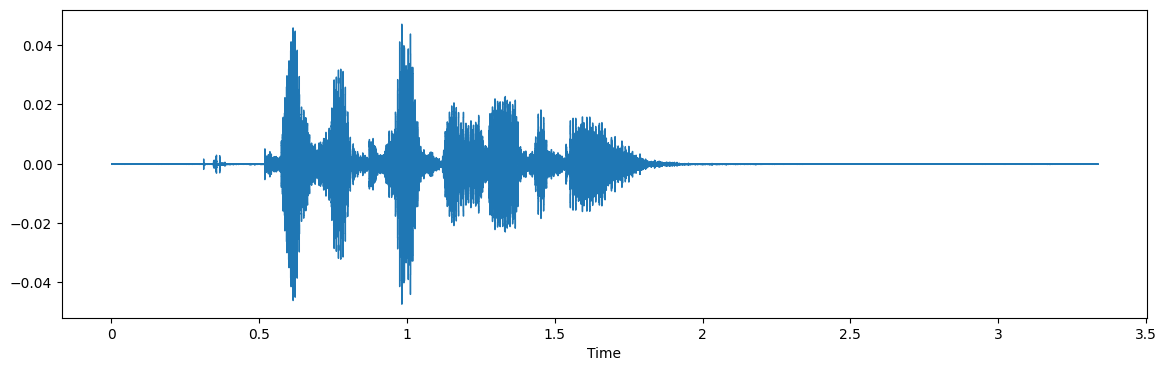

In [28]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5.5. Pitch (Tom)

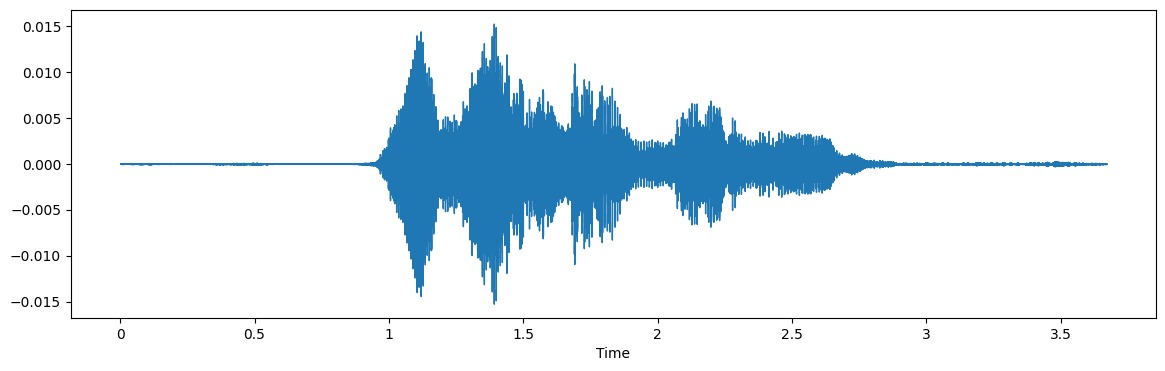

In [15]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

### 6. Preparando o dataframe para a extração das features

#### 6.1. Função para Padronizar Áudios

In [32]:
def preprocess_and_save_audio(input_path, output_dir, target_sr=16000):
    os.makedirs(output_dir, exist_ok=True)
    try:
        # Carregue o áudio com librosa.load e converta para mono
        # Code here

        # Determine o output_path, combinando o diretório de saída com o nome do arquivo de entrada
        # Code here

        # Salvar o áudio processado
        # 1. Carregar o áudio com librosa
        audio, sr = librosa.load(input_path, 
                               sr=target_sr,  # Resample para target_sr
                               mono=True)     # Converte para mono
        
        # 2. Normalizar o áudio para evitar clipping
        audio = librosa.util.normalize(audio)
        
        # 3. Gerar o caminho de saída
        filename = os.path.basename(input_path)
        output_path = os.path.join(output_dir, filename)
        
        # 4. Salvar o áudio processado
        sf.write(output_path, audio, target_sr, subtype='PCM_16')
        
        return output_path

    except Exception as e:
        print(f"Erro ao processar {input_path}: {e}")
        return None
    

#### 6.2. Aplicar a Padronização a Todos os Áudios

In [17]:
# Definir o caminho correto para salvar os áudios processados na pasta 'data' na raiz do projeto
processed_audio_dir = os.path.join(os.path.dirname(os.getcwd()), "data", "processed_audio")

# Criar o diretório se não existir
os.makedirs(processed_audio_dir, exist_ok=True)

print(f"Os arquivos serão salvos em: {processed_audio_dir}")


# Processar todos os áudios e salvar os novos caminhos
Ravdess_df["Processed_Path"] = Ravdess_df["Path"].apply(
    lambda x: preprocess_and_save_audio(x, processed_audio_dir)
)

# Remover arquivos que falharam no processamento
Ravdess_df = Ravdess_df[Ravdess_df["Processed_Path"].notnull()]

Os arquivos serão salvos em: /home/luigi/Documents/miniprojeto2/data/processed_audio


In [33]:
# Definir o caminho correto para salvar os áudios processados na pasta 'data' na raiz do projeto
project_root = os.path.dirname(os.path.dirname(os.path.abspath(__file__))) if "__file__" in locals() else os.getcwd()
processed_audio_dir = os.path.join(project_root, "data", "processed_audio")

# Criar o diretório se não existir
os.makedirs(processed_audio_dir, exist_ok=True)
print(f"Diretório de saída: {processed_audio_dir}")

# Processar todos os áudios e salvar os novos caminhos
print("Processando arquivos...")
success_count = 0

for idx, row in Ravdess_df.iterrows():
    processed_path = preprocess_and_save_audio(row['Path'], processed_audio_dir)
    Ravdess_df.at[idx, 'Processed_Path'] = processed_path
    if processed_path:
        success_count += 1
    if (idx + 1) % 100 == 0:  # Feedback a cada 100 arquivos
        print(f"Progresso: {idx + 1}/{len(Ravdess_df)} arquivos")

# Remover arquivos que falharam no processamento
Ravdess_df = Ravdess_df[Ravdess_df["Processed_Path"].notnull()]
print(f"\nConcluído! {success_count}/{len(Ravdess_df)} arquivos processados com sucesso.")

# 6. Salvar metadados
output_csv = os.path.join(project_root, "data", "processed_metadata.csv")
Ravdess_df.to_csv(output_csv, index=False)
print(f"Metadados salvos em: {output_csv}")

Diretório de saída: c:\Users\kawan\OneDrive\Documentos\reconhecimento\audio-emotion-classification\notebooks\data\processed_audio
Processando arquivos...
Progresso: 100/1440 arquivos
Progresso: 200/1440 arquivos
Progresso: 300/1440 arquivos
Progresso: 400/1440 arquivos
Progresso: 500/1440 arquivos
Progresso: 600/1440 arquivos
Progresso: 700/1440 arquivos
Progresso: 800/1440 arquivos
Progresso: 900/1440 arquivos
Progresso: 1000/1440 arquivos
Progresso: 1100/1440 arquivos
Progresso: 1200/1440 arquivos
Progresso: 1300/1440 arquivos
Progresso: 1400/1440 arquivos

Concluído! 1440/1440 arquivos processados com sucesso.
Metadados salvos em: c:\Users\kawan\OneDrive\Documentos\reconhecimento\audio-emotion-classification\notebooks\data\processed_metadata.csv


#### 6.3. Salvar o DataFrame Final

In [34]:
# Garantir que a pasta 'data' exista 
data_dir = os.path.join(os.path.dirname(os.getcwd()), "data")
os.makedirs(data_dir, exist_ok=True)

# Caminho correto para salvar o CSV na pasta 'data'
csv_path = os.path.join(data_dir, "ravdess_preprocessed.csv")

# Salvar o DataFrame no local correto, usa a função to_csv do pandas :)
# Code here

print(f"O arquivo foi salvo em: {csv_path}")

O arquivo foi salvo em: c:\Users\kawan\OneDrive\Documentos\reconhecimento\audio-emotion-classification\data\ravdess_preprocessed.csv


### Isso é tudo por aqui, você fez um ótimo trabalho e está indo muito bem!
#### Estamos prontos para o pŕoximo notebook, mas antes vamos ver as coisas que aprendemos até então:
- Criamos o dataframe (você mudou o path e entendeu a cara do nosso dataframe)
- Limpamos os dados (verificamos se existiam aúdios corrompidos)
- Plotamos gráficos (fizemos uns gráficos bem bonitos sobre o dataframe)
- Data augmentation (aplicamos algumas funções no aúdio para aumentar a quantidade de dados)
- Salvamos um dataframe com pandas (usamos to_csv)